In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from lmfit.models import ExponentialModel
mpl.style.use(['fivethirtyeight', 'figsize'])
_SAVEDIR_ = 'Tex/figures/'

In [59]:
def _ADR_matrix_PBC(cfld, cfla, kappa, NX, Nsteps):
    """
    To get DR matrix, just set cfla = 0
    """

    a = cfld + cfla/2
    b = cfld - cfla/2
    c = 1-2*cfld + kappa

    T = np.zeros([NX,NX])
    T[0][0] = c
    T[-1][-1] = c
    
    T[0][1] = b
    T[-1][-2] = a
    
    T[0][-1] = a
    T[-1][0] = b
    
    for n in range(1,NX-1):
        T[n][n-1]=a
        T[n][n]=c
        T[n][n+1]=b
        
    f = np.zeros([Nsteps, NX])

    sizex = 1
    dx = 1. /NX
    x = np.linspace(0,1,NX)

    sigma = .1*sizex
#     f[0][:] = np.exp(-.5*np.power((x[:]-sizex/2)/sigma,2))

    print(T)
    return T
def ADR_with_history(x,f, pot, dt, cfld, cfla, NX, Nsteps):
    T = _ADR_matrix_PBC(cfld, cfla, 0,  NX, Nsteps)
    np.fill_diagonal(T,T.diagonal()-pot*dt)
    dx    = np.abs(x[0]-x[1])
    
    for t in range(1,Nsteps):
        f[t] = np.dot(T,f[t-1])
    return x, f

def plot_10_percent(x,f,show=True):
    lw = 2
    
    stepsize = int(np.floor(f.shape[0]/10))
    plt.figure(figsize = (9,9))
    for step in np.arange(0,f.shape[0],stepsize):
        plt.plot(x,f[step],'k',alpha = .9*step/f.shape[0]+.1, lw = lw, label = np.int(step))

#     plt.ylim([0,1])
    plt.xlabel('x')
    plt.legend(fontsize = 14)
    if show:
        plt.show()
def plot_decay(f,Nsteps,NX,label):
    out = np.zeros([3,Nsteps])
    for i in range(Nsteps):
#         out[i] = np.sum(f[i]**2)
        out[0][i] = np.abs(f[i,int(NX/4)])
        out[1][i] = np.abs(f[i,int(NX/2)])
        out[2][i] = np.abs(f[i,int(3*NX/4)])
#         out[3][i] = f[i,int(NX/2)]
    plt.plot(list(range(Nsteps)),out[0],label="{:} NX/4".format(label))
    plt.plot(list(range(Nsteps)),out[1],label="{:} NX/2".format(label))
    plt.plot(list(range(Nsteps)),out[2],label="{:} 3 NX/4".format(label))
    return out

def do_fit(f,NX,Nsteps,dt,cut_low=8000,cut_high = -1):
    out = np.zeros([NX,Nsteps])
    mod = ExponentialModel()
#     print(f[:,1].shape)
#     cut = 40000


    decays = np.zeros(NX)
    pars =mod.guess(out[int(NX/4),:][cut_low:cut_high], x=np.array(range(Nsteps))[cut_low:cut_high]*dt)

    for i in range(NX):
        mod_out = mod.fit(out[i,:][cut_low:cut_high], pars, x=np.array(range(Nsteps))[cut_low:cut_high]*dt)
        decays[i] = mod_out.best_values['decay']
    return out,decays
def do_fit(f,NX,Nsteps,dt,cut_low=8000,cut_high = -1):
    out = np.zeros([NX,Nsteps])
    mod = ExponentialModel()
    print(f.shape)
    out = f[cut_low:cut_high]
    T = np.array(range(Nsteps))[cut_low:cut_high]*dt
    print(out.shape)
#     cut = 40000


    decays = np.zeros(NX)
    pars =mod.guess(out[:,int(NX/4)], x=T)

    for i in range(NX):
        mod_out = mod.fit(out[:,i], pars, x=T)
        decays[i] = mod_out.best_values['decay']
    return out,decays
# Params
Nsteps = 30000
nx = 100
NX = nx
sizeX = 10
x = np.linspace(-sizeX/2,sizeX/2,nx)
f = np.zeros([Nsteps,nx])
dx = x[1]-x[0]


dif = 1
vel = 0
v_amp = 1.0 #omega**2

cfl = .1 
if dif != 0:
    dtd = .5*dx**2/dif
else:
    dtd = 1.0
if vel != 0:
    dta = dx/vel
else:
    dta = 1
if v_amp != 0:
    dtc = 1/ (v_amp*sizeX**2)
else:
    dtc = 1

dt = cfl * np.min([dtd,dta,dtc])

alpha = vel*dt/dx
delta = dif*dt/(dx*dx)



In [60]:
print(dt)

0.000510152025304


[[ 0.9   0.05  0.   ...,  0.    0.    0.05]
 [ 0.05  0.9   0.05 ...,  0.    0.    0.  ]
 [ 0.    0.05  0.9  ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.    0.   ...,  0.9   0.05  0.  ]
 [ 0.    0.    0.   ...,  0.05  0.9   0.05]
 [ 0.05  0.    0.   ...,  0.    0.05  0.9 ]]
Propagated
(30000, 100)
(21999, 100)


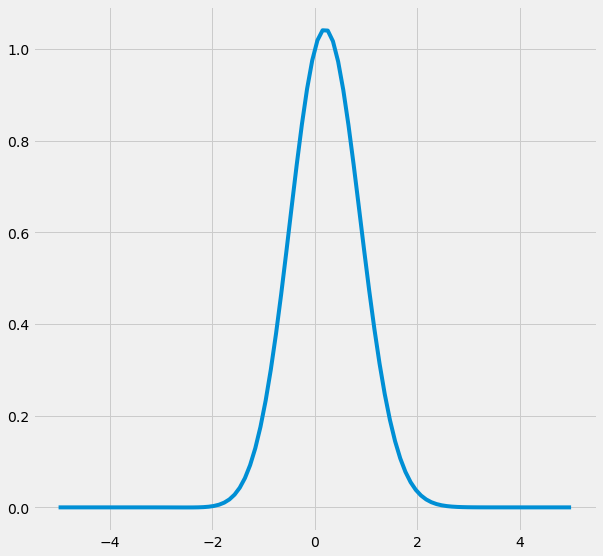

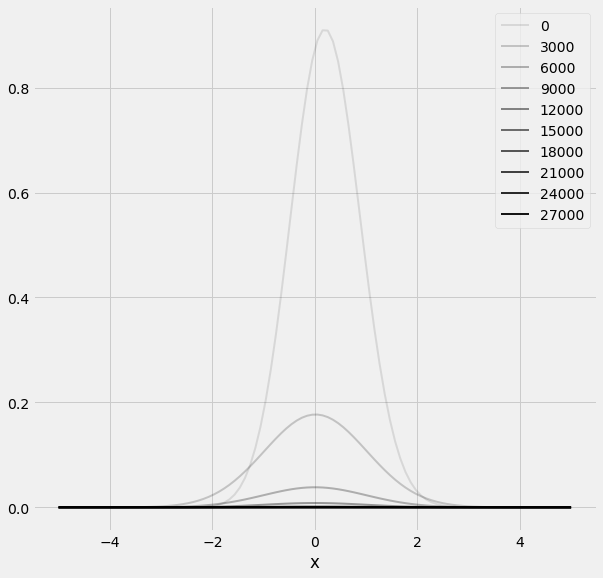

[[ 0.9   0.05  0.   ...,  0.    0.    0.05]
 [ 0.05  0.9   0.05 ...,  0.    0.    0.  ]
 [ 0.    0.05  0.9  ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.    0.   ...,  0.9   0.05  0.  ]
 [ 0.    0.    0.   ...,  0.05  0.9   0.05]
 [ 0.05  0.    0.   ...,  0.    0.05  0.9 ]]
Propagated
(30000, 100)
(21999, 100)


In [61]:
def compute(init,x,pot, delta, dt, Nsteps,NX):
    f = np.zeros([Nsteps,NX])
    f[0] = init
    out = ADR_with_history(x,f,pot,dt,delta, 0,NX,Nsteps)
    print("Propagated")
    decay_info = do_fit(out[1],NX,Nsteps,dt=dt)
    energy = 1/np.average(decay_info[1])
    return {'out':out,'energy':energy,'decay_info':decay_info}
def norm(f,x=x):
#     f /= np.sqrt(np.trapz(f**2,x))
    return f/np.sqrt(np.trapz(f**2,x))
def new_init(init,state):
    init  /= np.sqrt(np.trapz(init**2,x))
    state /= np.sqrt(np.trapz(state**2,x))
    c = np.trapz(init*state,x)
    new = init - c*state
    new /= np.sqrt(np.trapz(new**2,x))
    return c,new

# init = np.zeros_like(x)+(1+4*x**2+3*x**4+4*x**9)*np.exp(-x**2)
# Nsteps = 10000

init = np.ones_like(x)
init += np.random.rand(1)*x
# init += np.random.rand(1)*x**2
# init += np.random.rand(1)*x**3
# init += np.random.rand(1)*x**4
init *= np.exp(-x**2)
plt.plot(x,init)
pot = x**2
# plt.plot(x,init)
gs = compute(init,x,pot,delta,dt,Nsteps,NX)
init_2 = new_init(gs['out'][1][0],gs['out'][1][-1])[1]
plot_10_percent(gs['out'][0],gs['out'][1])
e1 = compute(init_2,x,pot,delta,dt,Nsteps,NX)

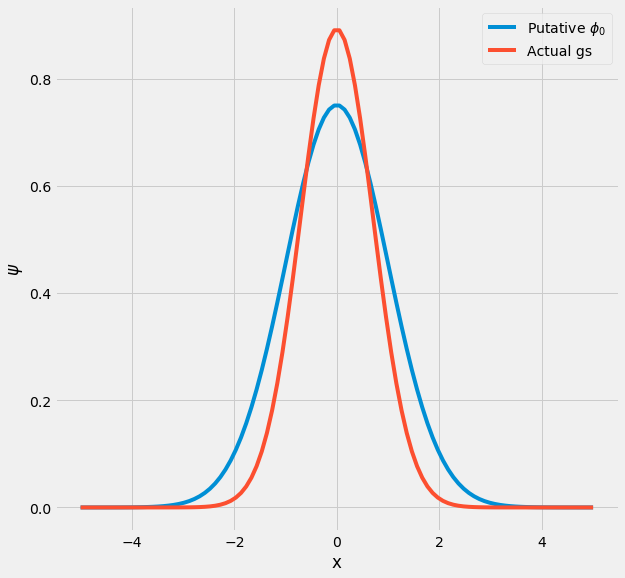

In [62]:
plt.plot(x,norm(gs['out'][1][-1]),label='Putative $\phi_0$')
plt.plot(x,norm(np.exp(-x**2)),label='Actual gs')
plt.legend()
plt.xlabel('x')
plt.ylabel('$\psi$')

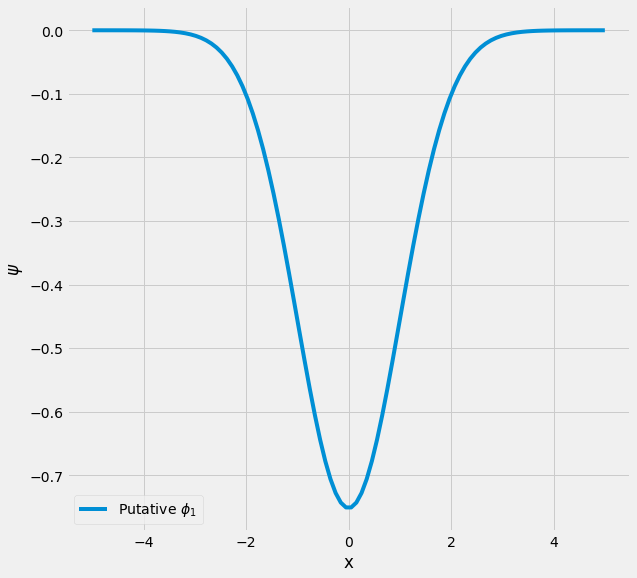

In [53]:
plt.plot(x,norm(e1['out'][1][-1]),label='Putative $\phi_1$')
plt.legend()
plt.xlabel('x')
plt.ylabel('$\psi$')

In [48]:
print(gs['energy'])
print(e1['energy'])

0.999616783726
2.99910017737


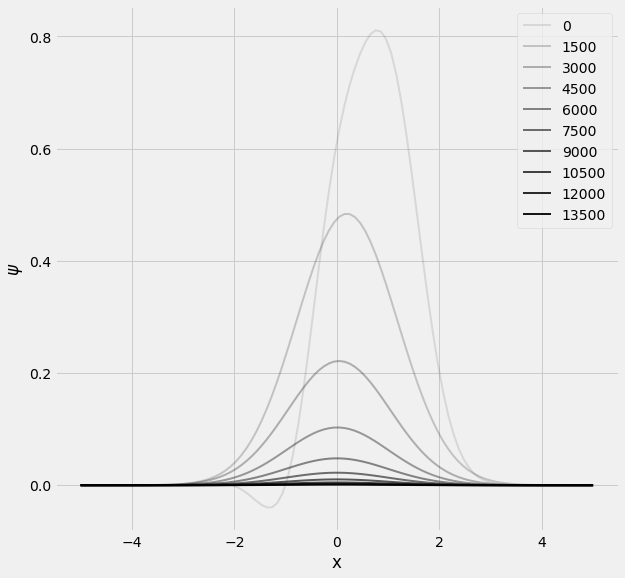

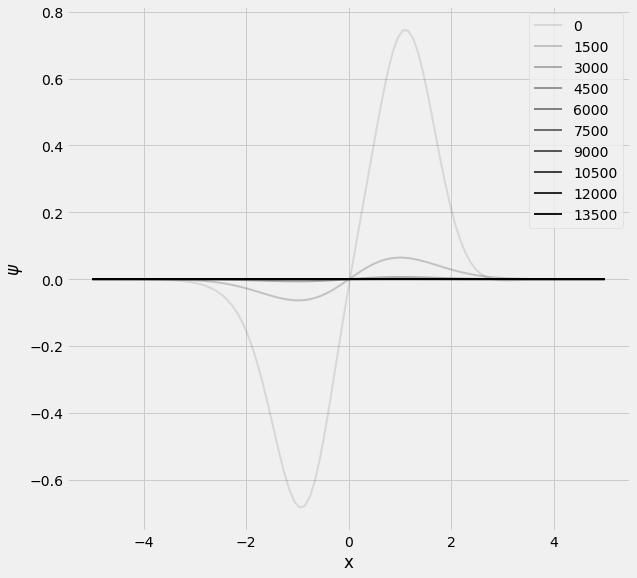

In [42]:
plot_10_percent(gs['out'][0],gs['out'][1],show=False)
plt.xlabel('x')
plt.ylabel('$\psi$')
plt.savefig(_SAVEDIR_+'ground_state_decay.png')

plot_10_percent(e1['out'][0],e1['out'][1],show=False)
plt.xlabel('x')
plt.ylabel('$\psi$')
plt.savefig(_SAVEDIR_+'e1_state_decay.png')

# plot_10_percent(gs['out'][0],gs['out'][1],show=False)
# plt.savefig(_SAVEDIR_+'ground_state_prop.png')


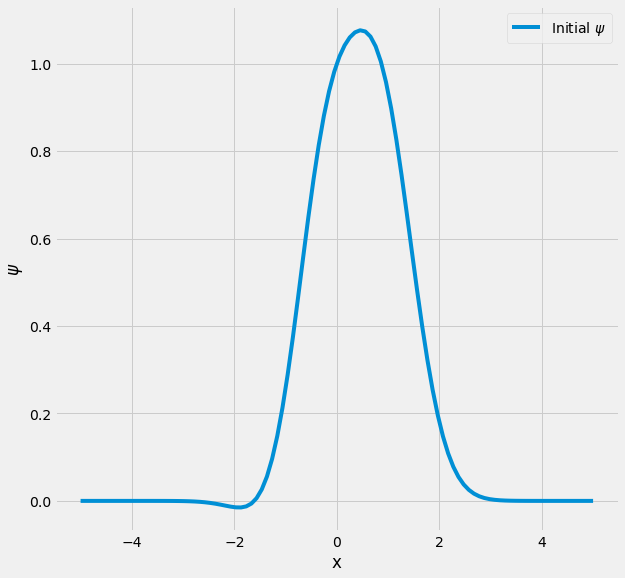

In [43]:
init = np.ones_like(x)
init += np.random.rand(1)*x
init += np.random.rand(1)*x**2
init += np.random.rand(1)*x**3
init += np.random.rand(1)*x**4
init *= np.exp(-x**2)
# plt.plot(x,init)
plt.plot(x,init, label = 'Initial $\psi$')
# plt.plot(x,e1['out'][1][0],label='Excited State Calc Initial $\psi$')
plt.legend()
plt.xlabel('x')
plt.ylabel('$\psi$')
plt.savefig(_SAVEDIR_+"ground_state_init.png")

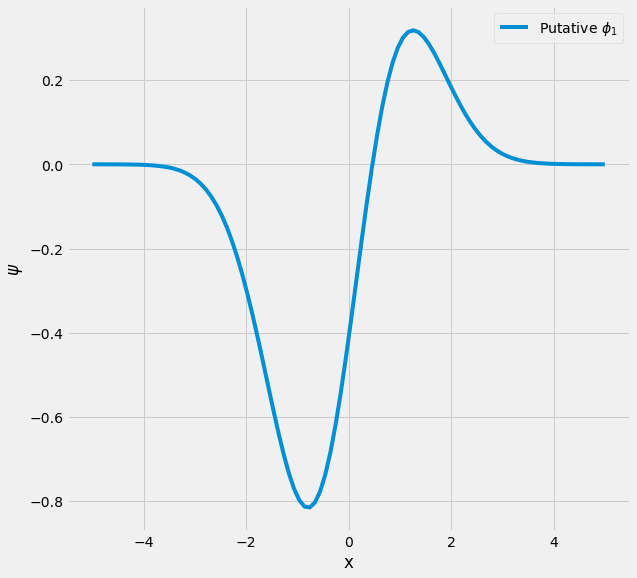

In [44]:
# plt.plot(x,init, label = 'Initial $\psi$')
plt.plot(x,norm(e1['out'][1][-1]),label='Putative $\phi_1$')
plt.legend()
plt.xlabel('x')
plt.ylabel('$\psi$')
plt.savefig(_SAVEDIR_+"phi1.png")

In [ ]:
plt.plot(x,init, label = 'Initial $\psi$')
plt.plot(x,norm(gs['out'][1][-1]),label='ground state')
plt.plot(x,norm(e1['out'][1][0]),label='Excited State Calc Initial $\psi$')
plt.legend()
plt.xlabel('x')
plt.ylabel('$\psi$')
plt.savefig(_SAVEDIR_+"excited_init.png")

In [ ]:
# plot_10_percent(e1['out'][0],e1['out'][1])
e1 = compute(init_2,x,pot,delta,dt,300000,NX)
plt.plot(x,norm(e1['out'][1][-2]))
plt.plot(x,norm(e1['out'][1][-1]))


In [ ]:
def get_coeff(init, state):
    init  /= np.sqrt(np.trapz(init**2,x))
    state /= np.sqrt(np.trapz(state**2,x))
    c = np.trapz(init*state,x)
    return c
def norm(f,x=x):
    f /= np.sqrt(np.trapz(f**2,x))
    return f

c0 = get_coeff(init, gs['out'][1][-1])
c1 = get_coeff(init, e1['out'][1][-1])
init_3 = norm(init) - c0*norm(gs['out'][1][-1])-c1*norm(e1['out'][1][-1])


In [ ]:
plot_10_percent(e1['out'][0],e1['out'][1])
init_3 = new_init(e1['out'][1][0],e1['out'][1][-1])[1]
e2 = compute(init_3,x,pot,delta,dt,Nsteps,NX)
plot_10_percent(e2['out'][0],e2['out'][1])
print(1/e2['energy'])

In [ ]:
def get_coeff(init, state):
    init  /= np.sqrt(np.trapz(init**2,x))
    state /= np.sqrt(np.trapz(state**2,x))
    c = np.trapz(init*state,x)
    return c
def norm(f,x=x):
#     f /= np.sqrt(np.trapz(f**2,x))
    return f /np.sqrt(np.trapz(f**2,x))

c0 = get_coeff(init, gs['out'][1][-1])
c1 = get_coeff(init, e1['out'][1][-1])
init_3 = norm(init) - c0*norm(gs['out'][1][-1])-c1*norm(e1['out'][1][-1])
# print(type(init_3))
plt.plot(x,norm(init) - c0*norm(gs['out'][1][-1]),label='init_1')
plt.plot(x,e1['out'][1][-1],label='e1')
plt.plot(x,norm(init_3),label='init_3')
plt.plot(x,norm(gs['out'][1][-1]))
plt.legend()
print(np.trapz(norm(gs['out'][1][-1])*norm(init_2),x))
print(np.trapz(norm(gs['out'][1][-1])*norm(e1['out'][1][-1]),x))
plt.show()

In [ ]:
e2 = compute(init_3,x,pot,delta,dt,Nsteps,NX)
plot_10_percent(e2['out'][0],e2['out'][1])
print(1/e2['energy'])

In [ ]:
print(gs['energy'])
print(e1['energy'])

In [ ]:

def do_fit(f,NX,Nsteps,cut_low=100000,cut_high = -1):
    out = np.zeros([NX,Nsteps])
    mod = ExponentialModel()
#     print(f[:,1].shape)
#     cut = 40000

    for j in range(Nsteps):
        out[:,j] = np.abs(f[j,:])
    decays = np.zeros(NX)
    pars =mod.guess(out[int(NX/4),:][cut_low:cut_high], x=np.array(range(Nsteps))[cut_low:cut_high]*dt)

    for i in range(NX):
        mod_out = mod.fit(out[i,:][cut_low:cut_high], pars, x=np.array(range(Nsteps))[cut_low:cut_high]*dt)
        decays[i] = mod_out.best_values['decay']
    return out,decays


decay_info = do_fit(e1['out'][1],NX,Nsteps,cut_low = 45000,cut_high = 100000)
print(np.average(decay_info[1]))


In [ ]:
1/.33

In [ ]:
plt.plot(list(range(Nsteps)),e1['out'][1][:,100])

In [ ]:
out = e1['out'][1]
mod = ExponentialModel()
cut1 = 35000
cut2 = 100000
# print(out[:,100])

pars =mod.guess(out[:,100][cut1:cut2], x=np.array(range(Nsteps))[cut1:cut2]*dt)

mod_out = mod.fit(out[:,100][cut1:cut2], pars, x=np.array(range(Nsteps))[cut1:cut2]*dt)
mod_out.plot_fit()
print(mod_out.fit_report())
plt.show()

In [ ]:
1/.4

In [ ]:
e1 = compute(init_2,x,pot,delta,dt,Nsteps,NX)
plot_10_percent(e1['out'][0],e1['out'][1])


In [ ]:
e1['energy']

In [ ]:
init = np.random.rand(NX)*np.exp(-x**2)
init = init*np.exp(-x**2)
plt.plot(x,init)

### Square Well

In [ ]:
pot_sqr = np.zeros(NX)
pot_sqr[np.abs(x)>=2.5]=100

init_sqr = np.ones_like(x)

max_pow = 4
for i in range(max_pow):
    init_sqr += np.random.rand(1)*x**(i+1)

plt.plot(x,init_sqr)
gs_sqr = compute(init,x,pot_sqr,delta,dt,Nsteps,NX)
init_sqr_2 = new_init(gs_sqr['out'][1][0],gs_sqr['out'][1][-1])[1]
plot_10_percent(gs_sqr['out'][0],gs_sqr['out'][1])
e1_sqr = compute(init_sqr_2,x,pot_sqr,delta,dt,Nsteps,NX)

In [ ]:
print(gs_sqr['energy'])
print(e1_sqr['energy'])

In [ ]:

plot_10_percent(out[0],out[1])
a = do_fit(out[1],NX,Nsteps)

plt.scatter(np.array(range(NX)), 1./a[1])
plt.xlabel('simulation point')
plt.ylabel('$\omega$')
plt.show()

### Trying to extract c0

In [ ]:

norm = np.sqrt(np.trapz(f[0]**2,x))
psi_0  =out[1][-1]
norm_0 = np.sqrt(np.trapz(psi_0**2,x))
plt.plot(x,psi_0/norm_0,label='gs')
plt.plot(x,f[0]/norm,label='Init')

init_norm = f[0]/norm
gs_norm = psi_0/norm_0

c0 = np.trapz(init_norm*gs_norm,x)
print(c0)

new_start = init_norm - c0*gs_norm
plt.plot(x,new_start,label='new')
plt.legend()

plt.show()


In [ ]:
print(np.average(1/a[1]))
print(np.average(1/a2[1]))
print(np.average(1/a2[1])/np.average(1/a[1]))

In [ ]:
np.sqrt(2)/2

In [ ]:
.7/np.sqrt(2)

In [ ]:
f = np.zeros([Nsteps, NX])
pot = .5*x**2

# f[0] = (1-out[1][-1])
f[0]=x*np.exp(-1/4*x**2)
# f[0] = 1
# f[0]=np.random.rand(NX)-.5
out2 = ADR_with_history(x,f,pot,dt,delta, 0,NX,Nsteps)


In [ ]:

plot_10_percent(out2[0],out2[1])
a2 = do_fit(out2[1],NX,Nsteps)

plt.scatter(np.array(range(NX)), 1./a2[1])
plt.xlabel('simulation point')
plt.ylabel('$\omega$')
plt.show()

In [ ]:

decar = np.zeros(NX)
# plt.plot(list(range(Nsteps)), out[1][:,250])
mod = ExponentialModel()


idx = 250
cut = 40000
pars =mod.guess(out[1][:,idx][cut:], x=np.array(range(Nsteps))[cut:]*dt)
result = mod.fit(out[1][:,idx][cut:], pars, x=np.array(range(Nsteps))[cut:]*dt)
result.plot_fit()
print(result.fit_report())

# Square Well


In [ ]:
pot_sqr = np.zeros(NX)
pot_sqr[np.abs(x)>=2.5]=100
plt.plot(x,pot_sqr)
plt.plot(x,np.sin(x*np.pi/2.5)+1)
plt.plot(x,np.cos(x*np.pi/2.5)+2+np.sin(x*np.pi/2.5))
plt.ylim([-5,5])



In [ ]:
f_sqr = np.zeros([Nsteps, NX])
f_sqr[0] = np.cos(x*np.pi/2.5)+np.sin(x*np.pi/2.5)+2
# f[0]=x
# f[0] = 1
# f[0]=np.random.rand(NX)-.5
out_sqr = ADR_with_history(x,f_sqr,pot_sqr,dt,delta, 0,NX,Nsteps)

In [ ]:
plot_10_percent(out_sqr[0],out_sqr[1],show=False)
plt.plot(x,pot_sqr)
plt.ylim([-.01,2])
plt.show()